# AOGS Workshop 2024: Analysing CMIP6 data.
## Create climate stripes by downloading CMIP6 data using ESGF-API

### Import all relevant modules

In [1]:
from pyesgf.search import SearchConnection
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

### Connect to one of the nodes server.

In [2]:
conn = SearchConnection('http://esgf-node.llnl.gov/esg-search',distrib=False)

### We will search for the same data as before.

In [3]:
ctx = conn.new_context(
    facets='project,experiment_id',
    project='CMIP6',
    table_id='Amon',
    institution_id="CSIRO-ARCCSS",
    experiment_id='historical',
    source_id='ACCESS-CM2',
    variable='tas',
    variant_label='r1i1p1f1',
)

### From the search query, the downloadable link for the file is extracted.

In [4]:
result = ctx.search()[0]
files = result.file_context().search()
opendap_url=files[0].opendap_url
opendap_url

'http://esgf-data1.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Amon/tas/gn/v20191108/tas_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc'

### Open the link as an xarray object.

In [5]:
de = xr.open_dataset(opendap_url,chunks={'time':480})
de

<xarray.Dataset> Size: 219MB
Dimensions:    (time: 1980, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 32kB dask.array<chunksize=(480, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 219MB dask.array<chunksize=(480, 144, 192), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    creation_date:                   2019-11-08T06:41:46Z
    ...                              ...
    variant_label:                   r1i1p1f1
    version:                         v20191108
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/d893128b-e107-4dcc-b543-46c...
    license:                         CMIP6 model data produced by CSIRO is li...
    DODS_EXTRA.Unlimited_Dimension:  time

### To create the climate stripes, let's compute a weighted global mean for the surface temperature using a function.

In [6]:
def global_mean(ds):
    lat = ds.lat
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

### Apply the function to calculate global weighted mean from 1981-2010.

In [23]:
dtn=global_mean(de.tas.sel(time=slice('1981-01-01','2010-12-31'))).groupby('time.year').mean()
dtn=dtn.load()

### Quickly plot to see the global temperature variations over time.

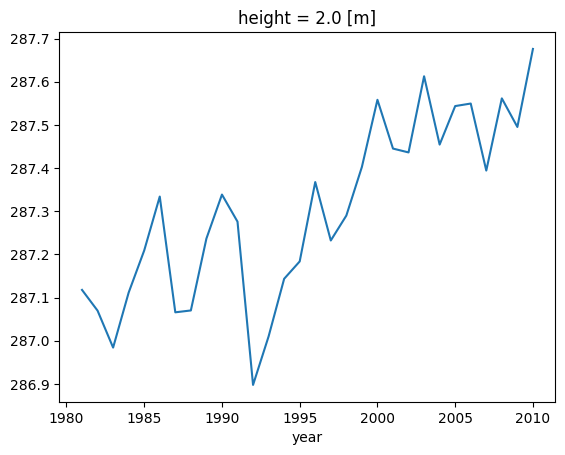

In [24]:
dtn.plot()

### Let's transform the line plot to climate stripes.

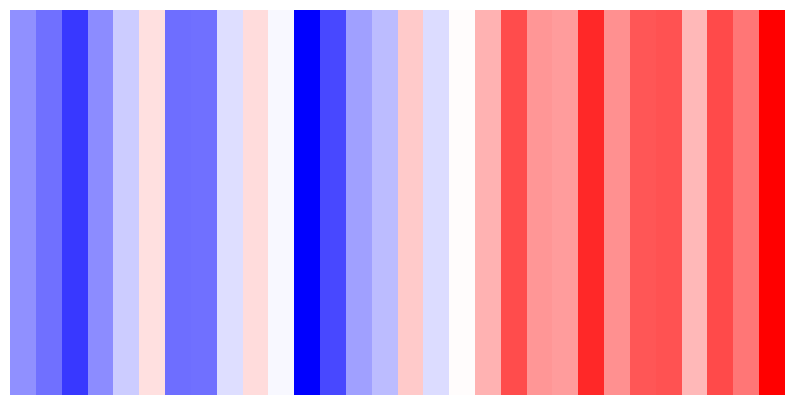

In [26]:
temperature = dtn
nx = len(temperature)
x = np.arange(len(temperature))
y = np.array([0, 1])
temperature = np.vstack([temperature, temperature])

figure, axes = plt.subplots(figsize=(10, 5))
axes.pcolormesh(x, y, temperature, cmap='bwr', shading='auto')
axes.set_axis_off()